In [64]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import random
import cv2

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras import regularizers, optimizers, layers, models, constraints 
from IPython.display import display
from tqdm import tqdm

random.seed()

%matplotlib inline
matplotlib.style.use('ggplot')

In [65]:
LFW_VS_LFW_DEEPFUNNELED = 'lfw-deepfunneled'
INPUT_DATA = 'output_data'


In [66]:
# NN PARAMETERS
EPOCHS = 40
BATCH_SIZE = 100
LEARNING_RATE = 0.02
NUMBER_OF_NEURONS = 1024
REGULARIZATION_LAMBDA = 0.05
FILTERS_NUMBER_1 = 24
FILTERS_NUMBER_2 = 48
FILTERS_SIZE = (4,4)

# CONVOLUTION PARAMETERS
IMG_SIZE = 64
CHANNELS = 3
NUM_OF_FEMALES = 3000
NUM_OF_MALES = 3000

In [67]:
def jj(*args):
    return os.path.join(*args)

def open_image(full_image_name):
#     return Image.open(full_image_name)
    flag = 1 if CHANNELS == 3 else 0
    return cv2.imread(full_image_name, flag)

def resize(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

def resize_dataset(dataset):
    result = []
    for img in dataset:
        new_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        result.append(new_img)
    return np.array(result)
    
def convert_to_array(img):
    return np.array(img, ndmin=3)

def get_gender_dataset(gender, number_of_imgs):
    faces_list = []
    for img_name in tqdm(os.listdir(jj(INPUT_DATA, LFW_VS_LFW_DEEPFUNNELED))):
        if img_name.startswith(gender):
            path = jj(INPUT_DATA, LFW_VS_LFW_DEEPFUNNELED, img_name)
            img = open_image(path)
            resized_img = resize(img)
            array = convert_to_array(resized_img)
            label = 0 if gender == 'f' else 1
            faces_list.append((array, label))

    random.shuffle(faces_list)

    return faces_list[:number_of_imgs]

def get_dataset():
    females = get_gender_dataset('f', NUM_OF_FEMALES)
    males = get_gender_dataset('m', NUM_OF_MALES)
    dataset = females + males
    random.shuffle(dataset)
    
    return dataset


In [68]:
# Create dataset: [(np.array(), np.array()), (...), ...]
# CREATED ONCE, TEST DATASET MUST BE UNTOUCH!

# dataset = get_dataset()
# len(dataset)


In [69]:
# Split dataset on train_and_validation dataset and test dataset
# CREATED ONCE, TEST DATASET MUST BE UNTOUCH!

# train_and_validation, test = train_test_split(dataset, test_size = 0.2, random_state = 0)
# x_test = np.asarray([i[0] for i in test])/255
# y_test = np.asarray([i[1] for i in test])

# WRITE DATASETS
# pickle.dump(train_and_validation, open("train_and_validation.data", "wb"))
# pickle.dump(test, open("test.data", "wb"))

# # READA DATASETS
# train_and_validation = pickle.load(open("train_and_validation.data", "rb"))
# test = pickle.load(open("test.data", "rb"))


In [70]:
# train, validation = train_test_split(train_and_validation, test_size = 0.2, random_state = 0)

# x_train = np.asarray([i[0] for i in train])/255
# y_train = np.asarray([i[1] for i in train])

# x_validation = np.asarray([i[0] for i in validation])/255
# y_validation = np.asarray([i[1] for i in validation])

# x_test = np.asarray([i[0] for i in test])/255
# y_test = np.asarray([i[1] for i in test])

In [71]:
# Resize images, use ONLY to resize DOWN

# x_new_train = resize_dataset(x_train)
# x_new_validation = resize_dataset(x_validation)

# x_train_and_validation = np.asarray([i[0] for i in train_and_validation])/255
# y_train_and_validation = np.asarray([i[1] for i in train_and_validation])

# x_test_new = resize_dataset(x_test)
# x_train_and_validation_new = resize_dataset(x_train_and_validation)


In [72]:
# Pot loss
def show_loss(history):   
    x_axis = range(0, EPOCHS)
    fig, ax = plt.subplots()
    ax.plot(x_axis, history.history['loss'], label='train_loss')
    ax.plot(x_axis, history.history['val_loss'], label='val_loss')
    ax.legend()
    plt.ylabel('Log loss')
    plt.xlabel('Epoch number')
    plt.title('Learning curves')
    
    plt.show()

In [73]:
# NN model

def nn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(filters=FILTERS_NUMBER_1,
                            kernel_size=FILTERS_SIZE,
                            strides=(1,1),
                            padding="same",
                            activation='relu',
                            use_bias=True,                            
                            input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
                           ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=FILTERS_NUMBER_2,
                            kernel_size=FILTERS_SIZE,
                            strides=(1,1),
                            padding="same",
                            activation='relu',
                            use_bias=True,                          
                           ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(NUMBER_OF_NEURONS,
                           activation='relu',
                           kernel_regularizer=regularizers.l2(REGULARIZATION_LAMBDA),
                          ))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    optimazier = optimizers.SGD(lr=LEARNING_RATE)
    model.compile(optimizer=optimazier,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [74]:
# LOAD SAVED MODEL TO CONTINUE TRAINING
# model = models.load_model("cnn_85.h5")

In [75]:
model = nn_model()
history = model.fit(x_train_and_validation_new, y_train_and_validation, validation_data=(x_test_new, y_test), verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE)


Train on 4772 samples, validate on 1193 samples
Epoch 1/40
4772/4772 [==============================] - ETA: 95s - loss: 95.1928 - acc: 0.520 - ETA: 60s - loss: 94.9057 - acc: 0.545 - ETA: 48s - loss: 94.6270 - acc: 0.533 - ETA: 42s - loss: 94.3461 - acc: 0.530 - ETA: 39s - loss: 94.0649 - acc: 0.538 - ETA: 36s - loss: 93.7867 - acc: 0.536 - ETA: 34s - loss: 93.5085 - acc: 0.538 - ETA: 32s - loss: 93.2321 - acc: 0.541 - ETA: 30s - loss: 92.9570 - acc: 0.537 - ETA: 29s - loss: 92.6806 - acc: 0.547 - ETA: 28s - loss: 92.4063 - acc: 0.547 - ETA: 26s - loss: 92.1332 - acc: 0.547 - ETA: 25s - loss: 91.8618 - acc: 0.546 - ETA: 25s - loss: 91.5905 - acc: 0.553 - ETA: 24s - loss: 91.3222 - acc: 0.552 - ETA: 23s - loss: 91.0525 - acc: 0.563 - ETA: 22s - loss: 90.7852 - acc: 0.567 - ETA: 21s - loss: 90.5185 - acc: 0.573 - ETA: 21s - loss: 90.2516 - acc: 0.581 - ETA: 20s - loss: 89.9899 - acc: 0.575 - ETA: 19s - loss: 89.7274 - acc: 0.573 - ETA: 18s - loss: 89.4651 - acc: 0.575 - ETA: 18s - loss:

4772/4772 [==============================] - ETA: 30s - loss: 30.3706 - acc: 0.770 - ETA: 29s - loss: 30.2669 - acc: 0.740 - ETA: 28s - loss: 30.1726 - acc: 0.730 - ETA: 28s - loss: 30.0664 - acc: 0.750 - ETA: 27s - loss: 29.9649 - acc: 0.764 - ETA: 26s - loss: 29.8733 - acc: 0.770 - ETA: 26s - loss: 29.7862 - acc: 0.771 - ETA: 25s - loss: 29.6999 - acc: 0.767 - ETA: 24s - loss: 29.6146 - acc: 0.765 - ETA: 24s - loss: 29.5345 - acc: 0.762 - ETA: 23s - loss: 29.4466 - acc: 0.766 - ETA: 22s - loss: 29.3555 - acc: 0.770 - ETA: 21s - loss: 29.2763 - acc: 0.764 - ETA: 21s - loss: 29.1906 - acc: 0.767 - ETA: 20s - loss: 29.1028 - acc: 0.770 - ETA: 20s - loss: 29.0197 - acc: 0.771 - ETA: 19s - loss: 28.9385 - acc: 0.769 - ETA: 18s - loss: 28.8576 - acc: 0.768 - ETA: 18s - loss: 28.7738 - acc: 0.768 - ETA: 17s - loss: 28.6888 - acc: 0.771 - ETA: 16s - loss: 28.6008 - acc: 0.775 - ETA: 16s - loss: 28.5199 - acc: 0.772 - ETA: 15s - loss: 28.4371 - acc: 0.773 - ETA: 15s - loss: 28.3534 - acc: 0.7

4772/4772 [==============================] - ETA: 29s - loss: 9.8197 - acc: 0.85 - ETA: 29s - loss: 9.8043 - acc: 0.83 - ETA: 29s - loss: 9.8071 - acc: 0.81 - ETA: 29s - loss: 9.7977 - acc: 0.79 - ETA: 28s - loss: 9.7721 - acc: 0.77 - ETA: 28s - loss: 9.7307 - acc: 0.78 - ETA: 27s - loss: 9.6934 - acc: 0.79 - ETA: 27s - loss: 9.6753 - acc: 0.78 - ETA: 26s - loss: 9.6422 - acc: 0.79 - ETA: 25s - loss: 9.6093 - acc: 0.79 - ETA: 24s - loss: 9.5798 - acc: 0.80 - ETA: 23s - loss: 9.5511 - acc: 0.80 - ETA: 23s - loss: 9.5209 - acc: 0.80 - ETA: 22s - loss: 9.5043 - acc: 0.79 - ETA: 21s - loss: 9.4803 - acc: 0.79 - ETA: 21s - loss: 9.4496 - acc: 0.80 - ETA: 20s - loss: 9.4241 - acc: 0.80 - ETA: 19s - loss: 9.3980 - acc: 0.80 - ETA: 18s - loss: 9.3689 - acc: 0.80 - ETA: 18s - loss: 9.3417 - acc: 0.80 - ETA: 17s - loss: 9.3169 - acc: 0.80 - ETA: 16s - loss: 9.2923 - acc: 0.80 - ETA: 16s - loss: 9.2678 - acc: 0.80 - ETA: 15s - loss: 9.2456 - acc: 0.80 - ETA: 14s - loss: 9.2185 - acc: 0.80 - ETA: 

4772/4772 [==============================] - ETA: 33s - loss: 3.4540 - acc: 0.84 - ETA: 32s - loss: 3.4331 - acc: 0.83 - ETA: 31s - loss: 3.4022 - acc: 0.83 - ETA: 31s - loss: 3.3728 - acc: 0.83 - ETA: 30s - loss: 3.3450 - acc: 0.84 - ETA: 29s - loss: 3.3459 - acc: 0.84 - ETA: 29s - loss: 3.3367 - acc: 0.84 - ETA: 28s - loss: 3.3237 - acc: 0.84 - ETA: 27s - loss: 3.3135 - acc: 0.84 - ETA: 26s - loss: 3.3046 - acc: 0.84 - ETA: 25s - loss: 3.3024 - acc: 0.83 - ETA: 25s - loss: 3.2945 - acc: 0.83 - ETA: 24s - loss: 3.2902 - acc: 0.83 - ETA: 23s - loss: 3.2894 - acc: 0.82 - ETA: 22s - loss: 3.2870 - acc: 0.82 - ETA: 21s - loss: 3.2809 - acc: 0.82 - ETA: 21s - loss: 3.2716 - acc: 0.82 - ETA: 20s - loss: 3.2634 - acc: 0.81 - ETA: 19s - loss: 3.2544 - acc: 0.82 - ETA: 18s - loss: 3.2493 - acc: 0.81 - ETA: 18s - loss: 3.2384 - acc: 0.81 - ETA: 17s - loss: 3.2311 - acc: 0.81 - ETA: 16s - loss: 3.2220 - acc: 0.81 - ETA: 16s - loss: 3.2125 - acc: 0.82 - ETA: 15s - loss: 3.2045 - acc: 0.81 - ETA: 

4772/4772 [==============================] - ETA: 31s - loss: 1.3638 - acc: 0.83 - ETA: 30s - loss: 1.3671 - acc: 0.83 - ETA: 29s - loss: 1.3426 - acc: 0.84 - ETA: 28s - loss: 1.3247 - acc: 0.85 - ETA: 28s - loss: 1.3178 - acc: 0.85 - ETA: 27s - loss: 1.3373 - acc: 0.83 - ETA: 26s - loss: 1.3578 - acc: 0.82 - ETA: 25s - loss: 1.3579 - acc: 0.82 - ETA: 25s - loss: 1.3488 - acc: 0.82 - ETA: 24s - loss: 1.3511 - acc: 0.82 - ETA: 23s - loss: 1.3562 - acc: 0.81 - ETA: 23s - loss: 1.3602 - acc: 0.81 - ETA: 22s - loss: 1.3530 - acc: 0.81 - ETA: 21s - loss: 1.3420 - acc: 0.82 - ETA: 21s - loss: 1.3383 - acc: 0.82 - ETA: 20s - loss: 1.3374 - acc: 0.82 - ETA: 19s - loss: 1.3315 - acc: 0.82 - ETA: 19s - loss: 1.3280 - acc: 0.82 - ETA: 18s - loss: 1.3205 - acc: 0.82 - ETA: 17s - loss: 1.3205 - acc: 0.82 - ETA: 17s - loss: 1.3158 - acc: 0.82 - ETA: 16s - loss: 1.3100 - acc: 0.82 - ETA: 15s - loss: 1.3047 - acc: 0.83 - ETA: 15s - loss: 1.2981 - acc: 0.83 - ETA: 14s - loss: 1.2935 - acc: 0.83 - ETA: 

4772/4772 [==============================] - ETA: 29s - loss: 0.7683 - acc: 0.79 - ETA: 29s - loss: 0.7274 - acc: 0.82 - ETA: 29s - loss: 0.6865 - acc: 0.85 - ETA: 29s - loss: 0.6891 - acc: 0.84 - ETA: 28s - loss: 0.7050 - acc: 0.84 - ETA: 27s - loss: 0.7033 - acc: 0.84 - ETA: 27s - loss: 0.7000 - acc: 0.84 - ETA: 26s - loss: 0.6939 - acc: 0.84 - ETA: 26s - loss: 0.6860 - acc: 0.84 - ETA: 25s - loss: 0.6836 - acc: 0.85 - ETA: 24s - loss: 0.6775 - acc: 0.85 - ETA: 24s - loss: 0.6846 - acc: 0.84 - ETA: 23s - loss: 0.6880 - acc: 0.84 - ETA: 22s - loss: 0.6840 - acc: 0.84 - ETA: 22s - loss: 0.6830 - acc: 0.84 - ETA: 21s - loss: 0.6780 - acc: 0.84 - ETA: 20s - loss: 0.6755 - acc: 0.85 - ETA: 19s - loss: 0.6748 - acc: 0.85 - ETA: 19s - loss: 0.6753 - acc: 0.84 - ETA: 18s - loss: 0.6798 - acc: 0.84 - ETA: 17s - loss: 0.6811 - acc: 0.84 - ETA: 17s - loss: 0.6791 - acc: 0.84 - ETA: 16s - loss: 0.6781 - acc: 0.84 - ETA: 15s - loss: 0.6762 - acc: 0.84 - ETA: 15s - loss: 0.6788 - acc: 0.84 - ETA: 

4772/4772 [==============================] - ETA: 32s - loss: 0.4137 - acc: 0.89 - ETA: 31s - loss: 0.4446 - acc: 0.87 - ETA: 30s - loss: 0.4569 - acc: 0.88 - ETA: 30s - loss: 0.4544 - acc: 0.88 - ETA: 29s - loss: 0.4490 - acc: 0.88 - ETA: 28s - loss: 0.4510 - acc: 0.88 - ETA: 27s - loss: 0.4521 - acc: 0.88 - ETA: 27s - loss: 0.4421 - acc: 0.89 - ETA: 26s - loss: 0.4469 - acc: 0.89 - ETA: 25s - loss: 0.4433 - acc: 0.89 - ETA: 25s - loss: 0.4447 - acc: 0.89 - ETA: 24s - loss: 0.4415 - acc: 0.89 - ETA: 23s - loss: 0.4434 - acc: 0.88 - ETA: 23s - loss: 0.4417 - acc: 0.89 - ETA: 22s - loss: 0.4445 - acc: 0.88 - ETA: 22s - loss: 0.4410 - acc: 0.89 - ETA: 21s - loss: 0.4366 - acc: 0.89 - ETA: 20s - loss: 0.4413 - acc: 0.88 - ETA: 19s - loss: 0.4381 - acc: 0.88 - ETA: 19s - loss: 0.4356 - acc: 0.89 - ETA: 18s - loss: 0.4331 - acc: 0.89 - ETA: 17s - loss: 0.4350 - acc: 0.88 - ETA: 17s - loss: 0.4356 - acc: 0.88 - ETA: 16s - loss: 0.4393 - acc: 0.88 - ETA: 15s - loss: 0.4405 - acc: 0.88 - ETA: 

4772/4772 [==============================] - ETA: 34s - loss: 0.3884 - acc: 0.87 - ETA: 31s - loss: 0.3400 - acc: 0.89 - ETA: 30s - loss: 0.3534 - acc: 0.89 - ETA: 29s - loss: 0.3559 - acc: 0.89 - ETA: 28s - loss: 0.3448 - acc: 0.90 - ETA: 28s - loss: 0.3421 - acc: 0.90 - ETA: 27s - loss: 0.3446 - acc: 0.90 - ETA: 26s - loss: 0.3532 - acc: 0.90 - ETA: 25s - loss: 0.3628 - acc: 0.89 - ETA: 25s - loss: 0.3621 - acc: 0.89 - ETA: 24s - loss: 0.3542 - acc: 0.90 - ETA: 23s - loss: 0.3488 - acc: 0.90 - ETA: 22s - loss: 0.3473 - acc: 0.90 - ETA: 22s - loss: 0.3457 - acc: 0.90 - ETA: 21s - loss: 0.3468 - acc: 0.90 - ETA: 20s - loss: 0.3487 - acc: 0.90 - ETA: 19s - loss: 0.3481 - acc: 0.90 - ETA: 19s - loss: 0.3485 - acc: 0.90 - ETA: 18s - loss: 0.3523 - acc: 0.89 - ETA: 17s - loss: 0.3541 - acc: 0.89 - ETA: 17s - loss: 0.3572 - acc: 0.89 - ETA: 16s - loss: 0.3596 - acc: 0.89 - ETA: 15s - loss: 0.3610 - acc: 0.89 - ETA: 15s - loss: 0.3619 - acc: 0.89 - ETA: 14s - loss: 0.3637 - acc: 0.89 - ETA: 

4772/4772 [==============================] - ETA: 29s - loss: 0.3658 - acc: 0.86 - ETA: 28s - loss: 0.3876 - acc: 0.86 - ETA: 28s - loss: 0.3842 - acc: 0.86 - ETA: 27s - loss: 0.3702 - acc: 0.88 - ETA: 27s - loss: 0.3613 - acc: 0.88 - ETA: 26s - loss: 0.3493 - acc: 0.89 - ETA: 25s - loss: 0.3409 - acc: 0.89 - ETA: 25s - loss: 0.3380 - acc: 0.89 - ETA: 24s - loss: 0.3388 - acc: 0.89 - ETA: 23s - loss: 0.3344 - acc: 0.89 - ETA: 23s - loss: 0.3291 - acc: 0.89 - ETA: 22s - loss: 0.3317 - acc: 0.89 - ETA: 21s - loss: 0.3384 - acc: 0.89 - ETA: 21s - loss: 0.3491 - acc: 0.89 - ETA: 20s - loss: 0.3474 - acc: 0.89 - ETA: 20s - loss: 0.3453 - acc: 0.89 - ETA: 19s - loss: 0.3443 - acc: 0.89 - ETA: 18s - loss: 0.3457 - acc: 0.89 - ETA: 18s - loss: 0.3429 - acc: 0.89 - ETA: 17s - loss: 0.3399 - acc: 0.89 - ETA: 17s - loss: 0.3381 - acc: 0.90 - ETA: 16s - loss: 0.3369 - acc: 0.90 - ETA: 16s - loss: 0.3347 - acc: 0.90 - ETA: 15s - loss: 0.3369 - acc: 0.90 - ETA: 15s - loss: 0.3372 - acc: 0.90 - ETA: 

4772/4772 [==============================] - ETA: 32s - loss: 0.2883 - acc: 0.95 - ETA: 30s - loss: 0.2789 - acc: 0.94 - ETA: 30s - loss: 0.2787 - acc: 0.94 - ETA: 30s - loss: 0.2885 - acc: 0.93 - ETA: 31s - loss: 0.2968 - acc: 0.93 - ETA: 31s - loss: 0.2897 - acc: 0.93 - ETA: 30s - loss: 0.3081 - acc: 0.92 - ETA: 30s - loss: 0.3118 - acc: 0.91 - ETA: 29s - loss: 0.3199 - acc: 0.91 - ETA: 28s - loss: 0.3209 - acc: 0.91 - ETA: 27s - loss: 0.3169 - acc: 0.91 - ETA: 26s - loss: 0.3177 - acc: 0.91 - ETA: 26s - loss: 0.3146 - acc: 0.91 - ETA: 25s - loss: 0.3138 - acc: 0.91 - ETA: 24s - loss: 0.3125 - acc: 0.91 - ETA: 24s - loss: 0.3135 - acc: 0.91 - ETA: 23s - loss: 0.3131 - acc: 0.91 - ETA: 22s - loss: 0.3096 - acc: 0.91 - ETA: 21s - loss: 0.3095 - acc: 0.91 - ETA: 20s - loss: 0.3119 - acc: 0.91 - ETA: 19s - loss: 0.3180 - acc: 0.91 - ETA: 19s - loss: 0.3210 - acc: 0.91 - ETA: 18s - loss: 0.3225 - acc: 0.90 - ETA: 17s - loss: 0.3226 - acc: 0.90 - ETA: 16s - loss: 0.3246 - acc: 0.90 - ETA: 

In [76]:
# Evaluate model
score = model.evaluate(x_test_new, y_test, batch_size=BATCH_SIZE)
score

1193/1193 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s     


[0.3621779902333086, 0.8759430099313037]

In [77]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 24)        1176      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 48)        18480     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 48)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              12583936  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
__________

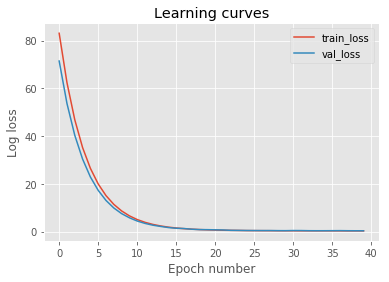

In [78]:
# Plot learning curves for validation and training data during learning
show_loss(history)

In [84]:
# SAVE MODEL TO A FILE
model.save("cnn_88_03.h5")

In [80]:
y_pred = model.predict(x_new_validation)
y_pred = np.round(y_pred.reshape(-1))

TP = np.count_nonzero(y_pred * y_validation)
TN = np.count_nonzero((y_pred - 1) * (y_validation - 1))
FP = np.count_nonzero(y_pred * (y_validation - 1))
FN = np.count_nonzero((y_pred - 1) * y_validation)

confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns =['actual 1', 'actual 0'], index=['predicted 1', 'predicted 0'])
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = metrics.accuracy_score(y_validation, y_pred)

print('precision = ', precision)
print('recall = ', recall)
print('accuracy = ', accuracy)
confusion_matrix


precision =  0.944558521560575
recall =  0.9504132231404959
accuracy =  0.946596858639


,actual 1,actual 0
predicted 1,460,27
predicted 0,24,444


In [81]:
y_pred_test = model.predict(x_test_new)
y_pred_test = np.round(y_pred_test.reshape(-1,))

TP = np.count_nonzero(y_pred_test * y_test)
TN = np.count_nonzero((y_pred_test - 1) * (y_test - 1))
FP = np.count_nonzero(y_pred_test * (y_test - 1))
FN = np.count_nonzero((y_pred_test - 1) * y_test)

confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns =['actual 1', 'actual 0'], index=['predicted 1', 'predicted 0'])
precision = TP / (TP + FP)
recall = TP / (TP + FN)
accuracy = metrics.accuracy_score(y_test, y_pred_test)

print('precision = ', precision)
print('recall = ', recall)
print('accuracy = ', accuracy)

confusion_matrix



precision =  0.8780487804878049
recall =  0.8809135399673735
accuracy =  0.875943000838


,actual 1,actual 0
predicted 1,540,75
predicted 0,73,505


In [93]:
img = open_image('2.jpg')
resized_img = resize(img)
array = convert_to_array(resized_img)/255
array = array.reshape((-1,64,64,3))
model.predict(array)

array([[ 0.47262713]], dtype=float32)